/tmp/ipykernel_24957/739273915.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  series = pd.read_csv('data/visitors.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)


            pageviews
date                 
2011-04-19        764
2011-04-25       1308
2011-05-02       1219
2011-05-09        777
2011-05-16       1098


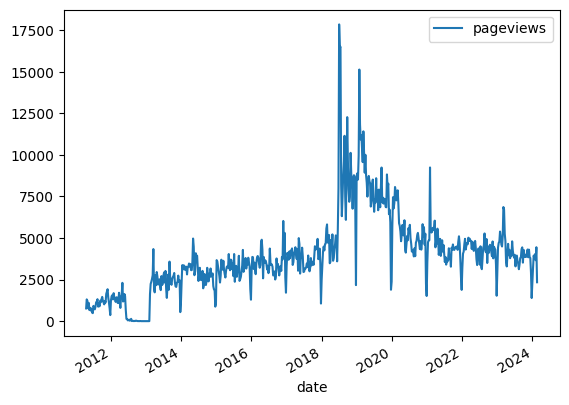

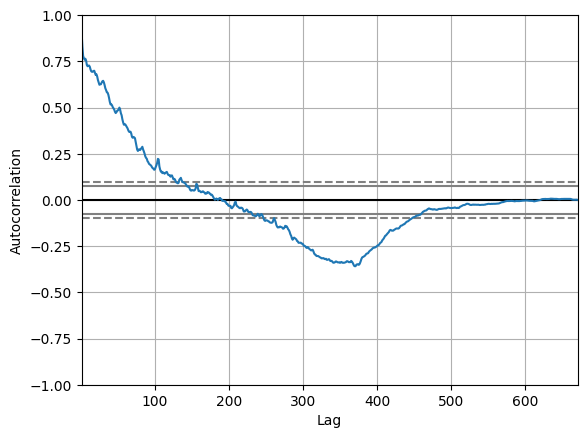

In [31]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
 
def parser(x):
 return datetime.strptime(x, '%Y-%m-%d')
 
series = pd.read_csv('data/visitors.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)
print(series.head())
series.plot()
plt.show()
pd.plotting.autocorrelation_plot(series)
plt.show()

In [32]:
hold_out_size = 52
series = series.astype(float)

# Create train and test sets
y_train = series.iloc[:-hold_out_size]
y_test = series.iloc[-hold_out_size:]

''' Fit the data using SARIMA(0,1,1)(0,1,1) '''
sarima = SARIMAX(y_train, order=(0, 1, 1),
                 seasonal_order=(0, 1, 1, 52),
                 trend=[0])
sarima_res = sarima.fit(disp=False)
print(sarima_res.summary())

/home/alex/git/bse-transformer-ts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alex/git/bse-transformer-ts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                          pageviews   No. Observations:                  619
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -4772.649
Date:                            Thu, 22 Feb 2024   AIC                           9551.297
Time:                                    14:18:07   BIC                           9564.313
Sample:                                         0   HQIC                          9556.377
                                            - 619                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2675      0.020    -13.160      0.000      -0.307      -0.228
ma.S.L52      -0.9914      0.019   

/home/alex/git/bse-transformer-ts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/alex/git/bse-transformer-ts/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


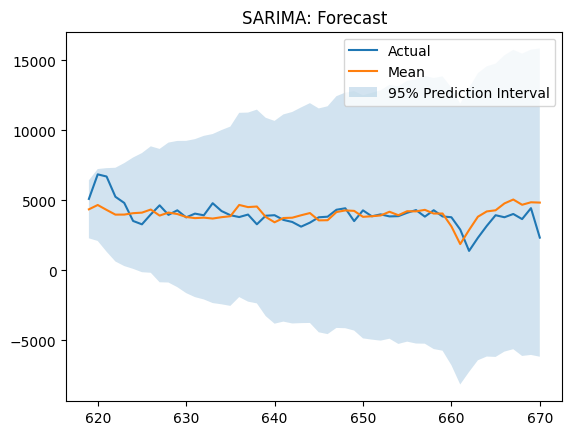

SARIMA RMSE: 865.1074799583525


In [33]:
# Get and plot forecast
pd.plotting.register_matplotlib_converters()
sarima_forecast = sarima_res.get_forecast(hold_out_size).summary_frame(alpha=0.05)
plt.plot(sarima_forecast.index, y_test)
plt.plot(sarima_forecast.index, sarima_forecast['mean'])
plt.fill_between(sarima_forecast.index,
                 sarima_forecast['mean_ci_lower'],
                 sarima_forecast['mean_ci_upper'], alpha=0.2)
plt.title('SARIMA: Forecast')
plt.legend(['Actual', 'Mean', '95% Prediction Interval'])
plt.show()

# Print RMSE
# Convenience function for computing root mean squared error
def rmse(actual, prediction):
    act, pred = actual.flatten(), prediction.flatten()
    return np.sqrt(np.mean((act - pred) ** 2))

print(f"SARIMA RMSE: {rmse(y_test.to_numpy(), sarima_forecast['mean'].to_numpy())}")